 # Logistic Regression
 ## 1. Import data to dataframes

In [459]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay


def load_data():
    # import the data
    current_dir = os.getcwd()
    basics_dir_path = os.path.join(current_dir, '..', 'data', 'section_1_basics')
    team_box_scores_dir_path = os.path.join(current_dir, '..', 'data', 'section_2_team_box_scores')
    geography_dir_path = os.path.join(current_dir, '..', 'data', 'section_3_geography')
    public_rankings_dir_path = os.path.join(current_dir, '..', 'data', 'section_4_public_rankings')
    supplements_dir_path = os.path.join(current_dir, '..','data', 'section_5_supplements')

    dfs = {}
    for path in [basics_dir_path, team_box_scores_dir_path, geography_dir_path, public_rankings_dir_path, supplements_dir_path]:
        for filename in os.listdir(path):
            if filename.endswith(".csv"):
                filepath = os.path.join(path, filename)
                df_name = filename[:-4]  # Remove the .csv extension
                dfs[df_name] = pd.read_csv(filepath)
    return dfs  
dfs = load_data()
dfs.keys()

dict_keys(['MNCAATourneyCompactResults', 'MNCAATourneySeeds', 'MRegularSeasonCompactResults', 'MSeasons', 'MTeams', 'WNCAATourneyCompactResults', 'WNCAATourneySeeds', 'WRegularSeasonCompactResults', 'WSeasons', 'WTeams', 'MNCAATourneyDetailedResults', 'MRegularSeasonDetailedResults', 'WNCAATourneyDetailedResults', 'WRegularSeasonDetailedResults', 'Cities', 'MGameCities', 'WGameCities', 'MMasseyOrdinals', 'Conferences', 'MConferenceTourneyGames', 'MNCAATourneySeedRoundSlots', 'MNCAATourneySlots', 'MSecondaryTourneyCompactResults', 'MSecondaryTourneyTeams', 'MTeamCoaches', 'MTeamConferences', 'MTeamSpellings', 'WConferenceTourneyGames', 'WNCAATourneySlots', 'WSecondaryTourneyCompactResults', 'WSecondaryTourneyTeams', 'WTeamConferences', 'WTeamSpellings'])

 ## 2. For this model we are going to use the data from `MRegularSeasonCompactResults.csv`

In [460]:
games = dfs['MRegularSeasonCompactResults']
coaches = dfs['MTeamCoaches']

 ## 3. Create a dataframe containing the regular game statistics for each match of each season. 
 #### Aggregate the data see the average points scored, average points scored against, and win percentage


In [461]:
def build_team_stats(df):
    winning_stats = df[['Season', 'WTeamID', 'WScore', 'LScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'PointsFor', 'LScore': 'PointsAgainst'}
    )
    winning_stats['Win'] = 1

    losing_stats = df[['Season', 'LTeamID', 'LScore', 'WScore']].rename(
        columns={'LTeamID': 'TeamID', 'LScore': 'PointsFor', 'WScore': 'PointsAgainst'}
    )
    losing_stats['Win'] = 0

    all_stats = pd.concat([winning_stats, losing_stats])

    # all_stats['MarginOfVictory'] = all_stats['PointsFor'] - all_stats['PointsAgainst']

    # aggregate data to see averaage points for and against, and win percentage
    team_stats = all_stats.groupby(['Season', 'TeamID']).agg(
    avg_points_for=('PointsFor', 'mean'),
    avg_points_against=('PointsAgainst', 'mean'),
    win_pct=('Win', 'mean')
    # avg_margin_of_victory=('MarginOfVictory', 'mean')  # Add margin of victory
    ).reset_index()

    return team_stats

team_stats = build_team_stats(games)


 ## 4. Create dataframe containing the matchups and merge in data from the statistics dataframe

In [462]:
def generate_matchups(games, team_stats, dfs):
    # Create labeled matchup data from real games
    matchups = games[['Season', 'WTeamID', 'LTeamID', 'DayNum']].copy()
    matchups['Team1ID'] = matchups['WTeamID']
    matchups['Team2ID'] = matchups['LTeamID']
    matchups['Team1Won'] = 1

    # Merge in features for both teams
    for i in [1, 2]:
        matchups = matchups.merge(
            team_stats,
            how='left',
            left_on=['Season', f'Team{i}ID'],
            right_on=['Season', 'TeamID']
        )
        matchups = matchups.rename(columns={
            'avg_points_for': f'Team{i}_avg_points_for',
            'avg_points_against': f'Team{i}_avg_points_against',
            'win_pct': f'Team{i}_win_pct'
        })
        matchups.drop(columns=['TeamID'], inplace=True)

    # randomly swap Team1 and Team2 
    np.random.seed(42)

    # Create a random boolean array: True means "swap"
    swap_mask = np.random.rand(len(matchups)) < 0.5

    # Swap team IDs by matching the mask
    matchups.loc[swap_mask, ['Team1ID', 'Team2ID']] = matchups.loc[swap_mask, ['Team2ID', 'Team1ID']].values
    for feature in ['avg_points_for', 'avg_points_against', 'win_pct']:
        team1_feature = f'Team1_{feature}'
        team2_feature = f'Team2_{feature}'
        matchups.loc[swap_mask, [team1_feature, team2_feature]] = matchups.loc[swap_mask, [team2_feature, team1_feature]].values

    # Set the target: 1 if original Team1 won, 0 if swapped
    matchups['Team1Won'] = (~swap_mask).astype(int)


    return matchups

matchups = generate_matchups(games, team_stats, dfs)


 ## 5. Build and test model

In [463]:

feature_cols = [
    'Team1_avg_points_for', 'Team1_avg_points_against', 'Team1_win_pct',
    'Team2_avg_points_for', 'Team2_avg_points_against', 'Team2_win_pct'
]

X = matchups[feature_cols]
y = matchups['Team1Won']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.7421


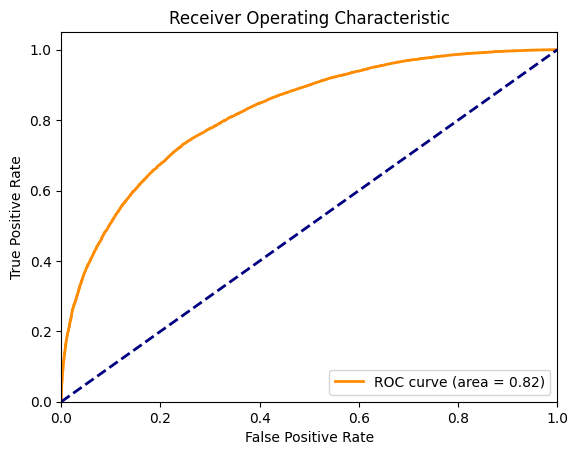

In [464]:
def plot_roc():

    # Compute ROC curve and ROC area for the model
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
plot_roc()

#### This model gives an accuracy of 74.21% and ROC 0.82

 ## 6. Add margin of victory to team stats to improve the model
 The margin of victory is the difference between the points scored by the winning team and the points scored by the losing team.
 This is a common feature used in sports analytics to predict the outcome of games.
 The margin of victory is a good predictor of the outcome of a game because it takes into account the strength of both teams.
 A team that wins by a large margin is likely to be stronger than a team that wins by a small margin.

 To do this, we will add the margin of victory to the team stats dataframe and then re-run the model.

In [465]:
def build_team_stats_MOV(df):
    winning_stats = df[['Season', 'WTeamID', 'WScore', 'LScore']].rename(
    columns={'WTeamID': 'TeamID', 'WScore': 'PointsFor', 'LScore': 'PointsAgainst'}
    )
    winning_stats['Win'] = 1

    losing_stats = df[['Season', 'LTeamID', 'LScore', 'WScore']].rename(
        columns={'LTeamID': 'TeamID', 'LScore': 'PointsFor', 'WScore': 'PointsAgainst'}
    )
    losing_stats['Win'] = 0

    all_stats = pd.concat([winning_stats, losing_stats])

    all_stats['MarginOfVictory'] = all_stats['PointsFor'] - all_stats['PointsAgainst']

    # aggregate data to see averaage points for and against, and win percentage
    team_stats = all_stats.groupby(['Season', 'TeamID']).agg(
    avg_points_for=('PointsFor', 'mean'),
    avg_points_against=('PointsAgainst', 'mean'),
    win_pct=('Win', 'mean'),
    avg_margin_of_victory=('MarginOfVictory', 'mean')  # Add margin of victory
    ).reset_index()

    return team_stats

team_stats = build_team_stats_MOV(games)

In [466]:
def generate_matchups_MOV(games, team_stats, dfs):
    # Create labeled matchup data from real games
    matchups = games[['Season', 'WTeamID', 'LTeamID', 'DayNum']].copy()
    matchups['Team1ID'] = matchups['WTeamID']
    matchups['Team2ID'] = matchups['LTeamID']
    matchups['Team1Won'] = 1

    # Merge in features for both teams
    for i in [1, 2]:
        matchups = matchups.merge(
            team_stats,
            how='left',
            left_on=['Season', f'Team{i}ID'],
            right_on=['Season', 'TeamID']
        )
        matchups = matchups.rename(columns={
            'avg_points_for': f'Team{i}_avg_points_for',
            'avg_points_against': f'Team{i}_avg_points_against',
            'win_pct': f'Team{i}_win_pct',
            'avg_margin_of_victory': f'Team{i}_avg_margin_of_victory'  # Add margin of victory
        })
        matchups.drop(columns=['TeamID'], inplace=True)

    # randomly swap Team1 and Team2 
    np.random.seed(42)

    # Create a random boolean array: True means "swap"
    swap_mask = np.random.rand(len(matchups)) < 0.5

    # Swap team IDs by matching the mask
    matchups.loc[swap_mask, ['Team1ID', 'Team2ID']] = matchups.loc[swap_mask, ['Team2ID', 'Team1ID']].values
    for feature in ['avg_points_for', 'avg_points_against', 'win_pct']:
        team1_feature = f'Team1_{feature}'
        team2_feature = f'Team2_{feature}'
        matchups.loc[swap_mask, [team1_feature, team2_feature]] = matchups.loc[swap_mask, [team2_feature, team1_feature]].values

    # Set the target: 1 if original Team1 won, 0 if swapped
    matchups['Team1Won'] = (~swap_mask).astype(int)

    # add ordinal rankings to matchups
    # matchups = merge_rankings(matchups, dfs)

    return matchups

matchups = generate_matchups_MOV(games, team_stats, dfs)

In [467]:
# Update feature columns to include margin of victory
feature_cols = [
    'Team1_avg_points_for', 'Team1_avg_points_against', 'Team1_win_pct', 'Team1_avg_margin_of_victory',
    'Team2_avg_points_for', 'Team2_avg_points_against', 'Team2_win_pct', 'Team2_avg_margin_of_victory'
]
# Build feature matrix and labels
X = matchups[feature_cols]
y = matchups['Team1Won']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
# Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy with Margin of Victory: {accuracy:.4f}")

Test Set Accuracy with Margin of Victory: 0.7419


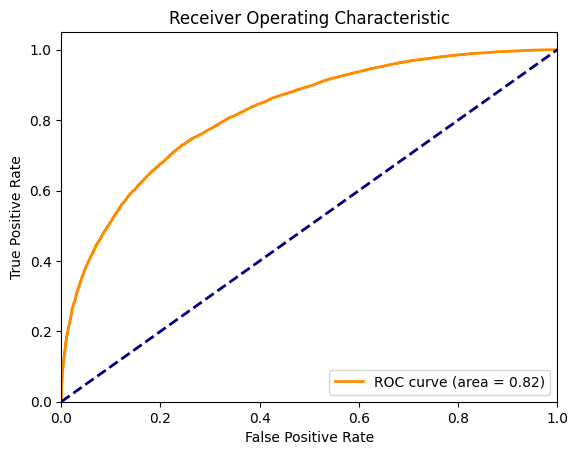

In [468]:
plot_roc()


 The model with the margin of victory feature has an accuracy of 74.19%.
 This is a decrease in performance for the model without the margin of victory feature.
 ROC = 0.82


 ## 6. Add Ranking Features
 We are going to use data from this file `MMasseyOrdinals.csv` to add ranking features to the model.
 This file contains the rankings of each team for each season. We will use the rankings to create new features for the model.
 The features we will create are:
 - Team1Rank: The ranking of Team1 for the season
 - Team2Rank: The ranking of Team2 for the season
 - Team1RankDiff: The difference between the rankings of Team1 and Team2
 - Team1RankDiffAbs: The absolute difference between the rankings of Team1 and Team2
 - Team1RankDiffPct: The percentage difference between the rankings of Team1 and Team2
 - Team1RankDiffPctAbs: The absolute percentage difference between the rankings of Team1 and Team2

In [469]:
def merge_rankings(matchups, dfs):
    # Load the rankings data
    rankings = dfs['MMasseyOrdinals']

    # keep only the relevant columns
    rankings = rankings[['Season', 'TeamID', 'OrdinalRank']]
    
    # keep the average ranking by season for each team
    rankings = rankings.groupby(['Season', 'TeamID']).agg(
        OrdinalRank=('OrdinalRank', 'mean')
    ).reset_index()

    # Add ordinal rankings for both Team1 and Team2
    for i in [1, 2]:
        matchups = matchups.merge(
            rankings, how='left',
            left_on=['Season', f'Team{i}ID'],
            right_on=['Season', 'TeamID']
        )
        matchups = matchups.drop(columns=['TeamID'])
        matchups = matchups.rename(columns={'OrdinalRank': f'Team{i}Rank'})

    # drop records with missing values in the rankings
    matchups = matchups.dropna(subset=['Team1Rank', 'Team2Rank'])

    # calculate rank difference
    matchups['Team1RankDiff'] = matchups['Team1Rank'] - matchups['Team2Rank']
    matchups['Team1RankDiffAbs'] = matchups['Team1RankDiff'].abs()
    matchups['Team1RankDiffPct'] = matchups['Team1RankDiff'] / matchups['Team2Rank']
    matchups['Team1RankDiffPctAbs'] = matchups['Team1RankDiffPct'].abs()

    return matchups

In [470]:
def generate_matchups_rank(games, team_stats, dfs):
    # Create labeled matchup data from real games
    matchups = games[['Season', 'WTeamID', 'LTeamID', 'DayNum']].copy()
    matchups['Team1ID'] = matchups['WTeamID']
    matchups['Team2ID'] = matchups['LTeamID']
    matchups['Team1Won'] = 1

    # Merge in features for both teams
    for i in [1, 2]:
        matchups = matchups.merge(
            team_stats,
            how='left',
            left_on=['Season', f'Team{i}ID'],
            right_on=['Season', 'TeamID']
        )
        matchups = matchups.rename(columns={
            'avg_points_for': f'Team{i}_avg_points_for',
            'avg_points_against': f'Team{i}_avg_points_against',
            'win_pct': f'Team{i}_win_pct',
            'avg_margin_of_victory': f'Team{i}_avg_margin_of_victory'  # Add margin of victory
        })
        matchups.drop(columns=['TeamID'], inplace=True)

    # randomly swap Team1 and Team2 
    np.random.seed(42)

    # Create a random boolean array: True means "swap"
    swap_mask = np.random.rand(len(matchups)) < 0.5

    # Swap team IDs by matching the mask
    matchups.loc[swap_mask, ['Team1ID', 'Team2ID']] = matchups.loc[swap_mask, ['Team2ID', 'Team1ID']].values
    for feature in ['avg_points_for', 'avg_points_against', 'win_pct']:
        team1_feature = f'Team1_{feature}'
        team2_feature = f'Team2_{feature}'
        matchups.loc[swap_mask, [team1_feature, team2_feature]] = matchups.loc[swap_mask, [team2_feature, team1_feature]].values

    # Set the target: 1 if original Team1 won, 0 if swapped
    matchups['Team1Won'] = (~swap_mask).astype(int)

    # add ordinal rankings to matchups
    matchups = merge_rankings(matchups, dfs)

    return matchups
matchups = generate_matchups_rank(games, team_stats, dfs)

In [471]:
# Update feature columns to include ranking features
feature_cols = [
    'Team1_avg_points_for', 'Team1_avg_points_against', 'Team1_win_pct', 
    'Team2_avg_points_for', 'Team2_avg_points_against', 'Team2_win_pct', 
    'Team1Rank', 'Team2Rank', 'Team1RankDiff', 'Team1RankDiffAbs', 'Team1RankDiffPct', 'Team1RankDiffPctAbs'
]
# Build feature matrix and labels
X = matchups[feature_cols]
y = matchups['Team1Won']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy with rankings: {accuracy:.10f}")

Test Set Accuracy with rankings: 0.7592947747


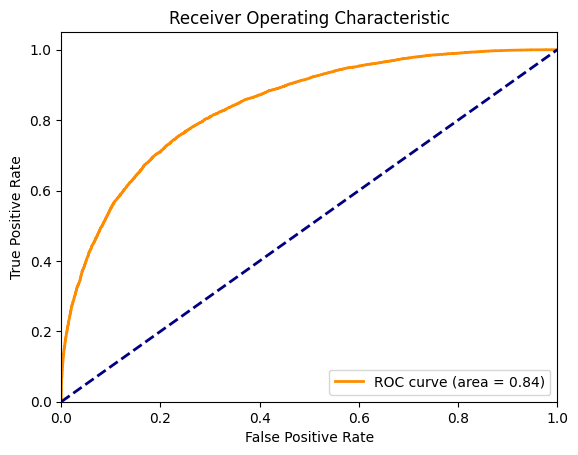

In [472]:
plot_roc()

#### Logistic regression model with the ordinal ranking data had an accuracy of 75.93% and ROC 0.84

# 7. Add seed data

In [473]:
def matchups_with_seed_data(matchups, dfs):
    # add seed data to matchups
    # generate matchups with seed data
    seeds = dfs['MNCAATourneySeeds']
    seeds['SeedNum'] = seeds['Seed'].str.extract('(\\d+)').astype(int)

    # Team1 seed
    matchups = matchups.merge(seeds[['Season', 'TeamID', 'SeedNum']], left_on=['Season', 'Team1ID'], right_on=['Season', 'TeamID'], how='left')
    matchups = matchups.rename(columns={'SeedNum': 'Team1Seed'}).drop(columns=['TeamID'])

    # Team2 seed
    matchups = matchups.merge(seeds[['Season', 'TeamID', 'SeedNum']], left_on=['Season', 'Team2ID'], right_on=['Season', 'TeamID'], how='left')
    matchups = matchups.rename(columns={'SeedNum': 'Team2Seed'}).drop(columns=['TeamID'])

    # Fill missing seeds with 17 (meaning worse than 16-seed)
    matchups.fillna({'Team1Seed': 17, 'Team2Seed': 17}, inplace=True)


    return matchups
matchups = generate_matchups_rank(games, team_stats, dfs)
seed_matchups = matchups_with_seed_data(matchups, dfs)

In [474]:
feature_cols = [
    'Team1_avg_points_for', 'Team1_avg_points_against', 'Team1_win_pct', 
    'Team2_avg_points_for', 'Team2_avg_points_against', 'Team2_win_pct', 
    'Team1Rank', 'Team2Rank', 'Team1RankDiff', 'Team1RankDiffAbs', 'Team1RankDiffPct', 'Team1RankDiffPctAbs',
    'Team1Seed', 'Team2Seed'
]
X = seed_matchups[feature_cols]
y = seed_matchups['Team1Won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with seed data: {accuracy:.10f}")

Model accuracy with seed data: 0.7591265435


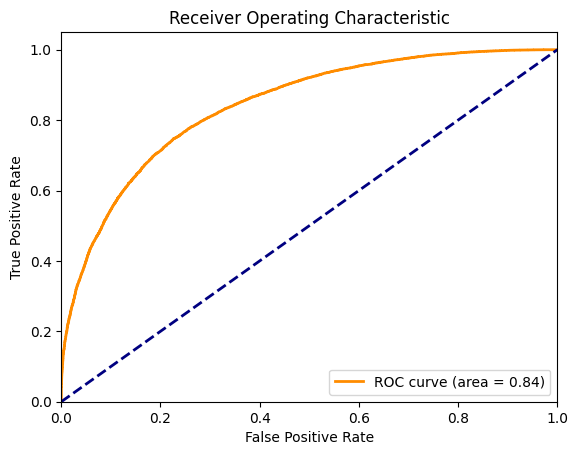

In [475]:
plot_roc()

#### Logistic regression model with seed data had an accuracy of 75.91% and ROC 0.84

 The model with the ordinal rankings feature is a better predictor of the outcome of a game, scoring an accuracy of 75.93%, than the model without these features. 

# Add coach win percentage

In [476]:
matchups = generate_matchups_rank(games, team_stats, dfs)
matchups.columns

Index(['Season', 'WTeamID', 'LTeamID', 'DayNum', 'Team1ID', 'Team2ID',
       'Team1Won', 'Team1_avg_points_for', 'Team1_avg_points_against',
       'Team1_win_pct', 'Team1_avg_margin_of_victory', 'Team2_avg_points_for',
       'Team2_avg_points_against', 'Team2_win_pct',
       'Team2_avg_margin_of_victory', 'Team1Rank', 'Team2Rank',
       'Team1RankDiff', 'Team1RankDiffAbs', 'Team1RankDiffPct',
       'Team1RankDiffPctAbs'],
      dtype='object')

In [477]:


matchups = generate_matchups_rank(games, team_stats, dfs)
# Add coach names to matchups
for i in [1, 2]:
    matchups = matchups.merge(
        coaches[['Season', 'TeamID', 'FirstDayNum', 'LastDayNum', 'CoachName']],
        how='left',
        left_on=['Season', f'Team{i}ID'],
        right_on=['Season', 'TeamID']
    )
    matchups = matchups[
        (matchups['DayNum'] >= matchups['FirstDayNum']) & 
        (matchups['DayNum'] <= matchups['LastDayNum'])
    ]
    matchups = matchups.rename(columns={'CoachName': f'Team{i}Coach'}).drop(columns=['TeamID', 'FirstDayNum', 'LastDayNum'])

In [478]:
# calculate win rates of the coaches
def calculate_coach_win_rates(matchups):
    # Calculate win rates for each coach
    coach_win_rates = matchups.groupby(['Season', 'Team1Coach']).agg(
        Team1Wins=('Team1Won', 'sum'),
        Team1Games=('Team1Won', 'count')
    ).reset_index()

    coach_win_rates['Team1WinRate'] = coach_win_rates['Team1Wins'] / coach_win_rates['Team1Games']

    # Merge with Team2 coaches
    team2_coach_win_rates = matchups.groupby(['Season', 'Team2Coach']).agg(
        Team2Wins=('Team1Won', lambda x: 1 - x.sum()),
        Team2Games=('Team1Won', 'count')
    ).reset_index()

    team2_coach_win_rates['Team2WinRate'] = team2_coach_win_rates['Team2Wins'] / team2_coach_win_rates['Team2Games']

    # concatenate both dataframes
    coach_win_rates = pd.concat([coach_win_rates, team2_coach_win_rates], ignore_index=True)

    return coach_win_rates
coach_win_rates = calculate_coach_win_rates(matchups)
# Merge win rates back into matchups
for i in [1, 2]:
    matchups = matchups.merge(
        coach_win_rates[['Season', f'Team{i}Coach', f'Team{i}WinRate']],
        how='left',
        left_on=['Season', f'Team{i}Coach'],
        right_on=['Season', f'Team{i}Coach']
    )
    matchups = matchups.rename(columns={f'Team{i}WinRate': f'Team{i}CoachWinRate'}).drop(columns=[f'Team{i}Coach'])
# Drop rows with NaN values in coach win rates
matchups = matchups.dropna(subset=['Team1CoachWinRate', 'Team2CoachWinRate'])


In [480]:
# Update feature columns to include coach win rates
feature_cols = [
    'Team1_avg_points_for', 'Team1_avg_points_against', 'Team1_win_pct', 
    'Team2_avg_points_for', 'Team2_avg_points_against', 'Team2_win_pct', 
    'Team1Rank', 'Team2Rank', 'Team1RankDiff', 'Team1RankDiffAbs', 'Team1RankDiffPct', 'Team1RankDiffPctAbs',
    'Team1CoachWinRate', 'Team2CoachWinRate'
]
# Build feature matrix and labels
X = matchups[feature_cols]
y = matchups['Team1Won']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
# Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy with Coach Win Rates: {accuracy:.10f}")



Test Set Accuracy with Coach Win Rates: 0.7752094479


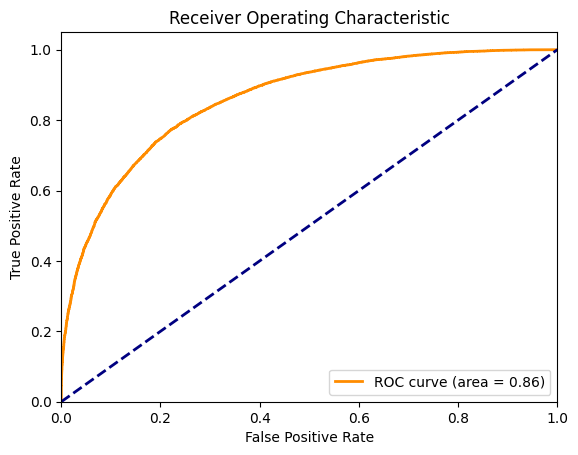

In [ ]:
plot_roc()

#### Model with margin of victory, ranking and coach win percentage had an increased accuracy of 77.52% and ROC 0.86

# 8. Random Forest
We will see if using the Random Forest Algorithm will produce better accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# matchups = generate_matchups(games, team_stats, dfs)
feature_cols = [
    'Team1_avg_points_for', 'Team1_avg_points_against', 'Team1_win_pct', 
    'Team2_avg_points_for', 'Team2_avg_points_against', 'Team2_win_pct', 
    'Team1Rank', 'Team2Rank', 'Team1RankDiff', 'Team1RankDiffAbs', 'Team1RankDiffPct', 'Team1RankDiffPctAbs',
    'Team1CoachWinRate', 'Team2CoachWinRate'
]
# Split data
X = matchups[feature_cols]
y = matchups['Team1Won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7298649955839677


### Using this random forest model, we get an accuracy of 71.97%